<a href="https://colab.research.google.com/github/alinaioanapopescu/popescu-alina-LA/blob/main/Proiect_LA_Popescu_Alina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# download dataset din kaggle (fara upload de fisier)
# cere username + api key, creeaza kaggle.json, descarca si dezarhiveaza

import os, json, glob
from getpass import getpass

dataset = "teejmahal20/airline-passenger-satisfaction"
data_dir = "/content/data"

kaggle_username = input("kaggle username: ").strip()
kaggle_key = getpass("kaggle api key (paste, hidden): ").strip()

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)

!pip -q install kaggle
os.makedirs(data_dir, exist_ok=True)

!kaggle datasets download -d {dataset} -p {data_dir} --unzip

print("files in /content/data:")
!ls -lah /content/data


kaggle username: alinapopescu
kaggle api key (paste, hidden): ··········
Dataset URL: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction
License(s): other
  0% 0.00/2.71M [00:00<?, ?B/s]
100% 2.71M/2.71M [00:00<00:00, 1.15GB/s]
files in /content/data:
total 15M
drwxr-xr-x 2 root root 4.0K Jan 29 09:44 .
drwxr-xr-x 1 root root 4.0K Jan 29 09:19 ..
-rw-r--r-- 1 root root 2.9M Jan 29 09:44 test.csv
-rw-r--r-- 1 root root  12M Jan 29 09:44 train.csv


In [9]:
# detectare automata train/test in folderul de date

import glob

data_dir = "/content/data"
csv_files = sorted(glob.glob(f"{data_dir}/*.csv"))
print("csv files:", csv_files)

train_path = None
test_path = None

for p in csv_files:
    name = p.lower()
    if "train" in name and train_path is None:
        train_path = p
    if "test" in name and test_path is None:
        test_path = p

# fallback daca nu gaseste dupa nume
if train_path is None and len(csv_files) >= 1:
    train_path = csv_files[0]
if test_path is None and len(csv_files) >= 2:
    test_path = csv_files[1]

print("train_path:", train_path)
print("test_path:", test_path)


csv files: ['/content/data/test.csv', '/content/data/train.csv']
train_path: /content/data/train.csv
test_path: /content/data/test.csv


In [10]:
# pornire spark + citire csv

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("airline_satisfaction_project").getOrCreate()

train_df_raw = spark.read.option("header", True).option("inferSchema", True).csv(train_path)
test_df_raw  = spark.read.option("header", True).option("inferSchema", True).csv(test_path)

print("train rows raw:", train_df_raw.count(), "| test rows raw:", test_df_raw.count())
print("train cols raw:", len(train_df_raw.columns))


train rows raw: 103904 | test rows raw: 25976
train cols raw: 25


In [12]:
# split train -> train_split/val_split

train_split, val_split = train_df.randomSplit([0.8, 0.2], seed=42)
train_split = train_split.cache()
val_split   = val_split.cache()

print("train_split:", train_split.count(), "| val_split:", val_split.count(), "| test:", test_df.count())


train_split: 82816 | val_split: 20778 | test: 25893


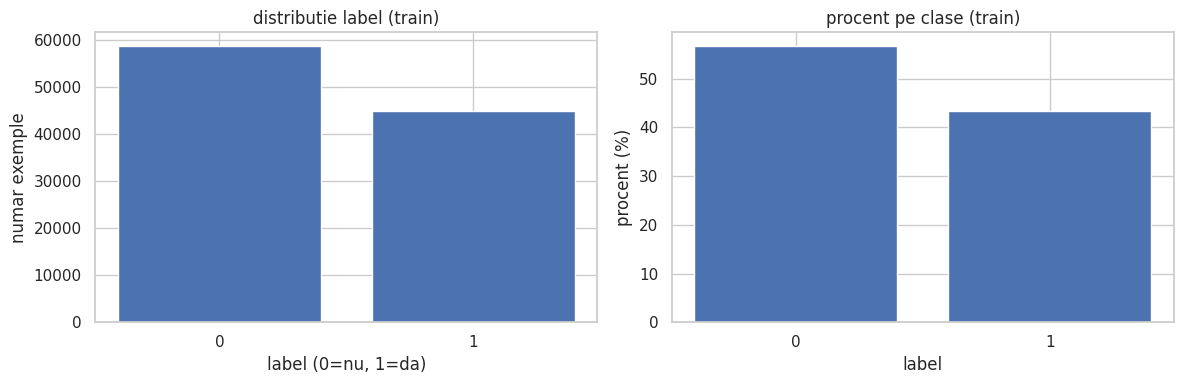

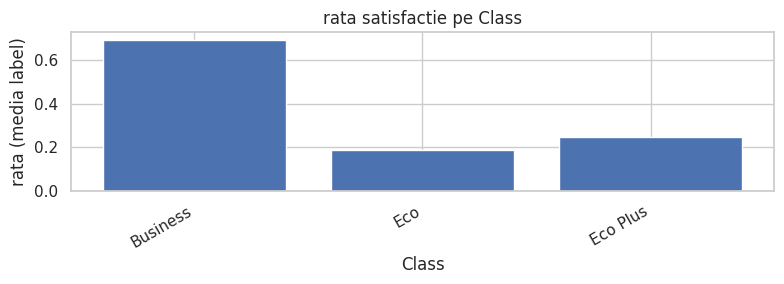

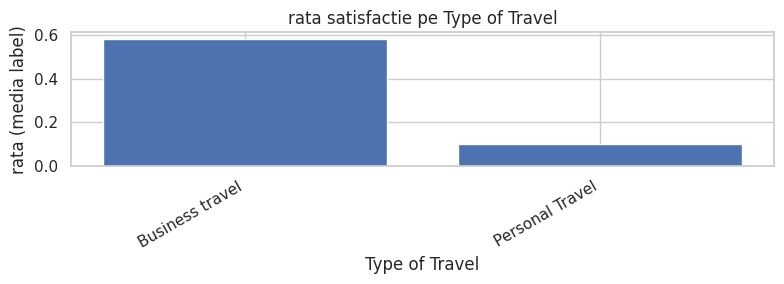

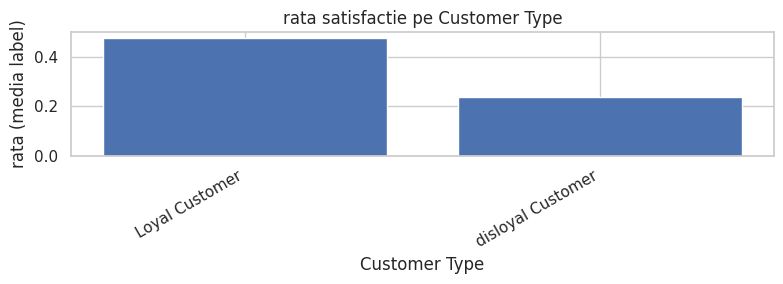

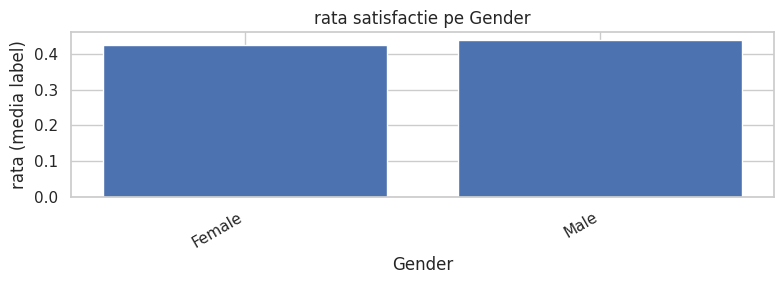

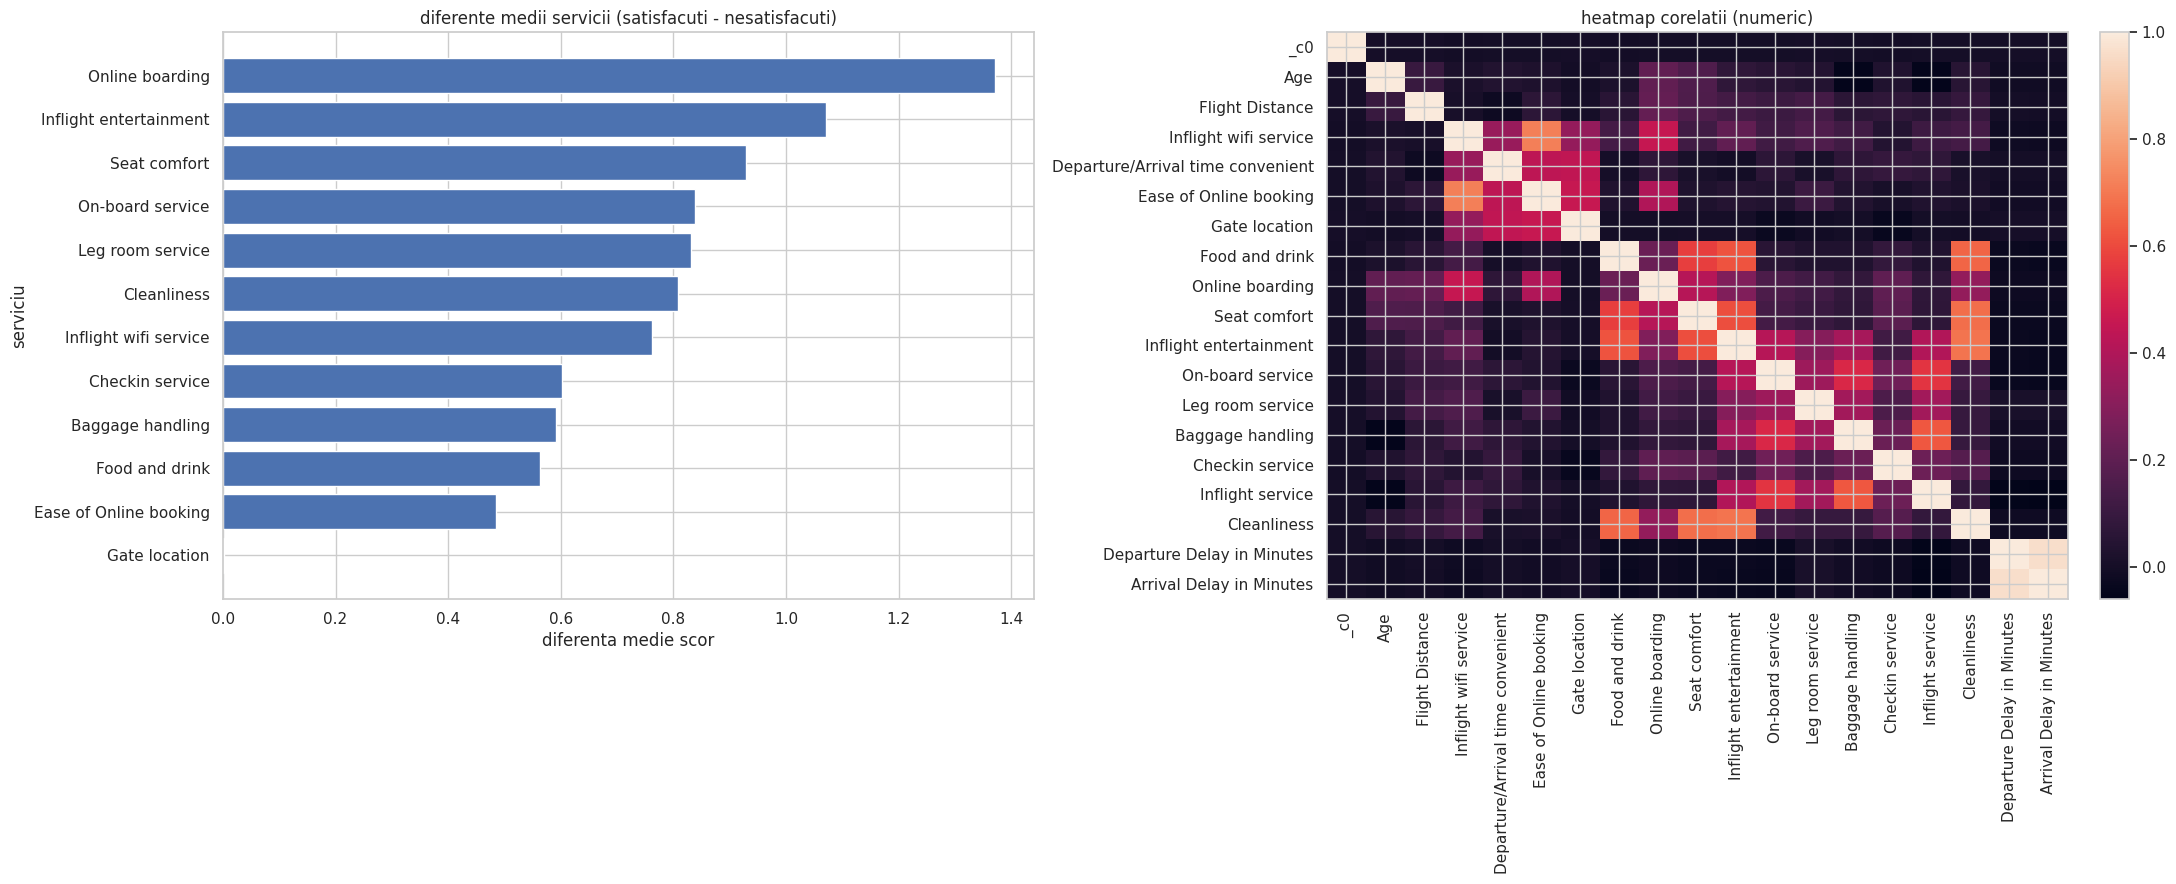

In [13]:
distributie label + rate pe categorii + servicii vs label + corelatii (grid)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, count, avg
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# distributie label (count + procent)
label_pdf = train_df.groupBy("label").agg(count("*").alias("n")).orderBy("label").toPandas()
total = int(label_pdf["n"].sum())
label_pdf["pct"] = (label_pdf["n"] / total) * 100

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(label_pdf["label"].astype(str), label_pdf["n"])
ax[0].set_title("distributie label (train)")
ax[0].set_xlabel("label (0=nu, 1=da)")
ax[0].set_ylabel("numar exemple")

ax[1].bar(label_pdf["label"].astype(str), label_pdf["pct"])
ax[1].set_title("procent pe clase (train)")
ax[1].set_xlabel("label")
ax[1].set_ylabel("procent (%)")
plt.tight_layout()
plt.show()

# rata satisfactie pe categorii (top dupa marimea grupului)
def plot_rate_by_category(df, colname, top_n=30):
    if colname not in df.columns:
        return
    pdf = (df.groupBy(colname)
           .agg(avg(col("label")).alias("rate"), count("*").alias("n"))
           .orderBy(col("n").desc())
           .limit(top_n)
           .toPandas())
    plt.figure(figsize=(8, 3))
    plt.bar(pdf[colname].astype(str), pdf["rate"])
    plt.title(f"rata satisfactie pe {colname}")
    plt.xlabel(colname)
    plt.ylabel("rata (media label)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

for c in ["Class", "Type of Travel", "Customer Type", "Gender"]:
    plot_rate_by_category(train_df, c)

# diferente medii pe servicii (satisfacuti - nesatisfacuti) + heatmap corelatii intr-un grid
service_cols = [
    "Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking",
    "Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service",
    "Baggage handling","Checkin service","Cleanliness","Food and drink","Gate location"
]
service_cols = [c for c in service_cols if c in train_df.columns]

diff = None
if service_cols:
    mean0 = train_df.filter(col("label")==0).agg(*[avg(col(c)).alias(c) for c in service_cols]).toPandas().iloc[0]
    mean1 = train_df.filter(col("label")==1).agg(*[avg(col(c)).alias(c) for c in service_cols]).toPandas().iloc[0]
    diff = (mean1 - mean0).sort_values(ascending=False).head(12)

num_cols_corr = [c for c, t in train_df.dtypes if t != "string" and c != "label"]
corr_mat = None
if len(num_cols_corr) >= 3:
    vec_df = VectorAssembler(inputCols=num_cols_corr, outputCol="num_features").transform(
        train_df.select(num_cols_corr).na.drop()
    )
    corr = Correlation.corr(vec_df, "num_features", "pearson").head()[0]
    corr_mat = np.array(corr.toArray())

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

ax0 = axes[0]
if diff is not None and len(diff) > 0:
    ax0.barh(list(reversed(diff.index.tolist())), list(reversed(diff.values.tolist())))
    ax0.set_title("diferente medii servicii (satisfacuti - nesatisfacuti)")
    ax0.set_xlabel("diferenta medie scor")
    ax0.set_ylabel("serviciu")
else:
    ax0.text(0.5, 0.5, "nu am gasit coloane de servicii", ha="center", va="center")
    ax0.set_axis_off()

ax1 = axes[1]
if corr_mat is not None:
    im = ax1.imshow(corr_mat, aspect="auto")
    ax1.set_title("heatmap corelatii (numeric)")
    ax1.set_xticks(range(len(num_cols_corr)))
    ax1.set_yticks(range(len(num_cols_corr)))
    ax1.set_xticklabels(num_cols_corr, rotation=90)
    ax1.set_yticklabels(num_cols_corr)
    fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
else:
    ax1.text(0.5, 0.5, "prea putine coloane numerice", ha="center", va="center")
    ax1.set_axis_off()

plt.tight_layout()
plt.show()


In [14]:
# celula 6) modele: preprocesare + antrenare 3 modele + evaluare (auc/accuracy/f1) pe val si test

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LinearSVC, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# coloane categorice / numerice
cat_cols = [c for c, t in train_split.dtypes if t == "string" and c != "label"]
num_cols = [c for c, t in train_split.dtypes if t != "string" and c != "label"]

# preprocesare (index -> onehot -> assembler)
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in cat_cols],
    outputCols=[f"{c}_ohe" for c in cat_cols]
)
assembler = VectorAssembler(
    inputCols=num_cols + [f"{c}_ohe" for c in cat_cols],
    outputCol="features",
    handleInvalid="keep"
)
preproc = indexers + [encoder, assembler]

# 3 modele
models_list = [
    ("linearsvc", LinearSVC(featuresCol="features", labelCol="label", maxIter=50, regParam=0.1)),
    ("random_forest", RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200, maxDepth=12, seed=42)),
    ("gbt", GBTClassifier(featuresCol="features", labelCol="label", maxIter=80, maxDepth=6, stepSize=0.1, seed=42)),
]

# evaluatori
eval_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
eval_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

def eval_all(pred_df):
    return {
        "auc": float(eval_auc.evaluate(pred_df)),
        "accuracy": float(eval_acc.evaluate(pred_df)),
        "f1": float(eval_f1.evaluate(pred_df)),
    }

fitted = {}
val_results = []
test_results = []

for name, clf in models_list:
    print("antrenare:", name)
    pipe = Pipeline(stages=preproc + [clf])
    m = pipe.fit(train_split)
    fitted[name] = m

    pred_val = m.transform(val_split)
    pred_test = m.transform(test_df)

    val_results.append({"model": name, **eval_all(pred_val)})
    test_results.append({"model": name, **eval_all(pred_test)})

val_df = pd.DataFrame(val_results).sort_values("auc", ascending=False)
test_df_metrics = pd.DataFrame(test_results).sort_values("auc", ascending=False)

print("\nrezultate validation (ordonate dupa auc):")
print(val_df)

print("\nrezultate test (ordonate dupa auc):")
print(test_df_metrics)


antrenare: linearsvc
antrenare: random_forest
antrenare: gbt

rezultate validation (ordonate dupa auc):
           model       auc  accuracy        f1
2            gbt  0.992194  0.953605  0.953519
1  random_forest  0.992062  0.952883  0.952853
0      linearsvc  0.925137  0.874386  0.873750

rezultate test (ordonate dupa auc):
           model       auc  accuracy        f1
2            gbt  0.992423  0.955471  0.955411
1  random_forest  0.991990  0.954698  0.954676
0      linearsvc  0.924110  0.871085  0.870528


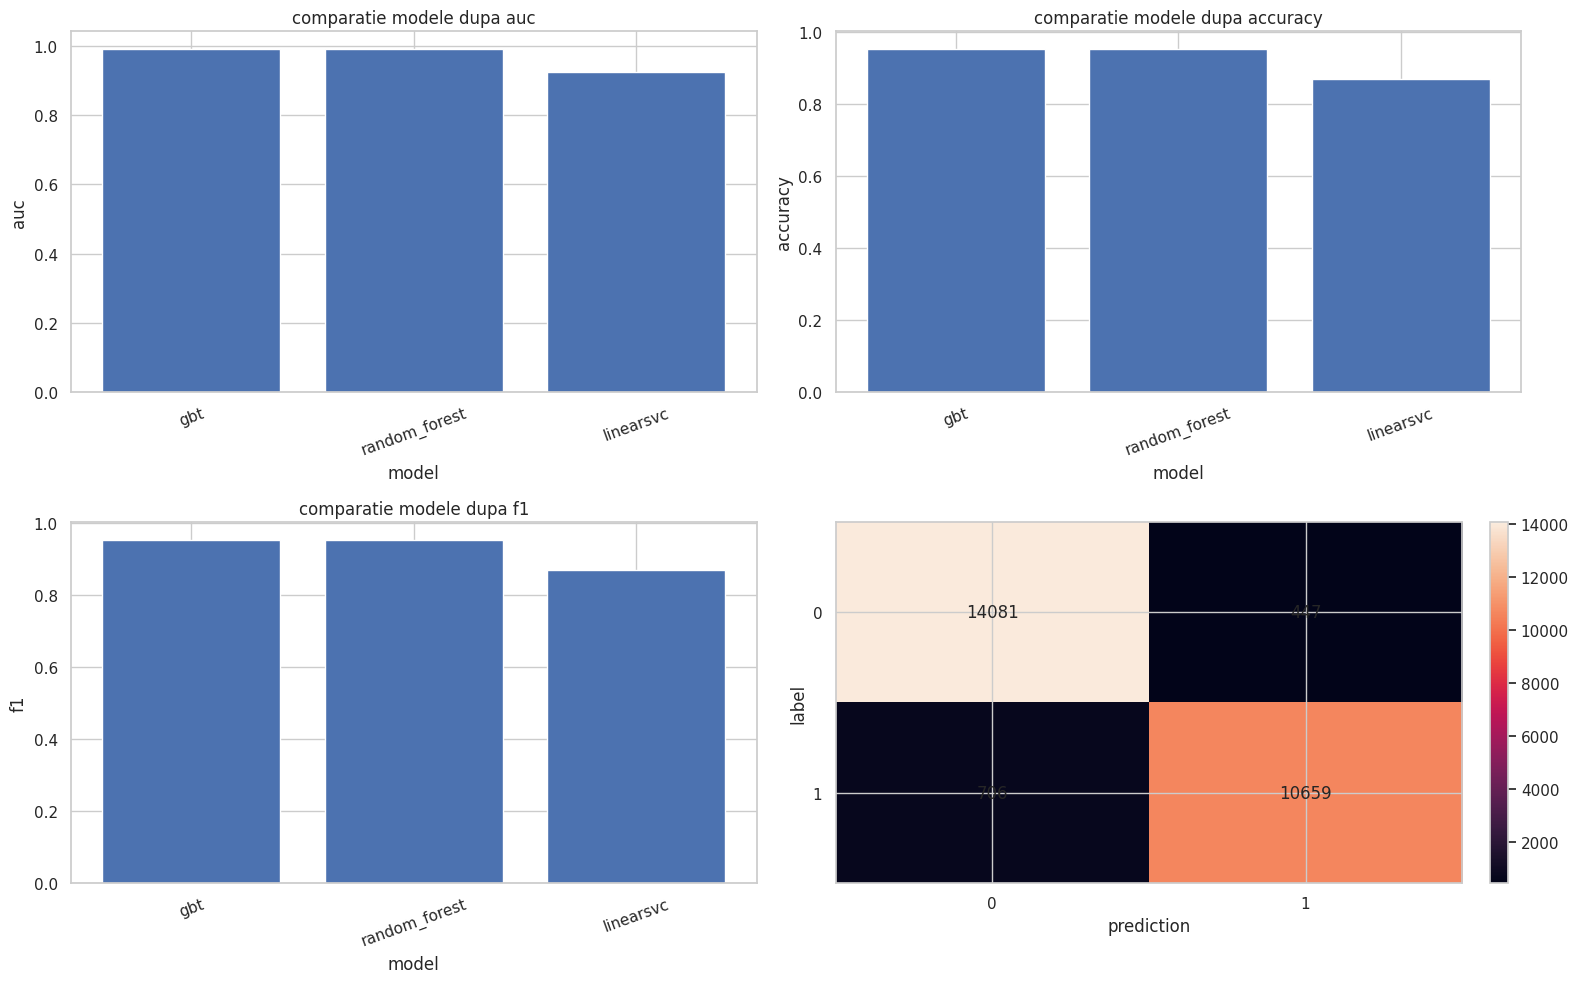

In [18]:

import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import count

# ordonam modelele dupa auc
res = test_df_metrics.sort_values("auc", ascending=False)

# confusion matrix pentru best model
best_name = res.iloc[0]["model"]
best_pred = fitted[best_name].transform(test_df).select("label", "prediction")

cm_pdf = best_pred.groupBy("label", "prediction").agg(count("*").alias("n")).toPandas()
mat = np.zeros((2, 2), dtype=int)
for _, r in cm_pdf.iterrows():
    mat[int(r["label"]), int(r["prediction"])] = int(r["n"])

# grid 2x2: 3 metrici + matricea de confuzie
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) auc
axes[0, 0].bar(res["model"], res["auc"])
axes[0, 0].set_title("comparatie modele dupa auc")
axes[0, 0].set_xlabel("model")
axes[0, 0].set_ylabel("auc")
axes[0, 0].tick_params(axis="x", rotation=20)

# 2) accuracy
axes[0, 1].bar(res["model"], res["accuracy"])
axes[0, 1].set_title("comparatie modele dupa accuracy")
axes[0, 1].set_xlabel("model")
axes[0, 1].set_ylabel("accuracy")
axes[0, 1].tick_params(axis="x", rotation=20)

# 3) f1
axes[1, 0].bar(res["model"], res["f1"])
axes[1, 0].set_title("comparatie modele dupa f1")
axes[1, 0].set_xlabel("model")
axes[1, 0].set_ylabel("f1")
axes[1, 0].tick_params(axis="x", rotation=20)

# 4) confusion matrix (colormap diferit)
im = axes[1, 1].imshow(mat, aspect="auto")
axes[1, 1].set_xlabel("prediction")
axes[1, 1].set_ylabel("label")
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(["0", "1"])
axes[1, 1].set_yticklabels(["0", "1"])

for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, str(mat[i, j]), ha="center", va="center")

fig.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [21]:
from pyspark.sql.functions import col, when, count, avg, min as spark_min, max as spark_max
from pyspark.ml.feature import Bucketizer

def binned_rate_pdf(df, xcol, bins=20, clip_max=None):
    # construieste bins si calculeaza:
    # - rata satisfactie (media label) pe bin
    # - numarul de observatii pe bin
    if xcol not in df.columns:
        return None

    work = df.select("label", col(xcol).cast("double").alias(xcol)).na.drop()

    # clip optional (ex: intarzieri pana la 180)
    if clip_max is not None:
        work = work.withColumn(
            xcol,
            when(col(xcol) > float(clip_max), float(clip_max)).otherwise(col(xcol))
        )

    stats = work.agg(spark_min(col(xcol)).alias("vmin"), spark_max(col(xcol)).alias("vmax")).collect()[0]
    vmin, vmax = float(stats["vmin"]), float(stats["vmax"])
    if vmin == vmax:
        return None

    step = (vmax - vmin) / bins
    splits = [vmin + i * step for i in range(bins + 1)]
    splits[0] = -float("inf")
    splits[-1] = float("inf")

    bucketizer = Bucketizer(splits=splits, inputCol=xcol, outputCol="bin")
    binned = bucketizer.transform(work)

    pdf = (binned.groupBy("bin")
           .agg(avg(col("label")).alias("rate"), count("*").alias("n"))
           .orderBy(col("bin"))
           .toPandas())

    # centrele bins (pentru axa x)
    centers = [(vmin + i * step + vmin + (i + 1) * step) / 2 for i in range(bins)]

    # pastram doar bin-urile reale 0..bins-1
    pdf = pdf[pdf["bin"].between(0, bins - 1)].copy()
    pdf["center"] = centers[:len(pdf)]

    return pdf


pdf is None? False
rows: 25


,bin,rate,n,center
0,0.0,0.455346,72200,3.6
1,1.0,0.424091,7621,10.8
2,2.0,0.399074,4969,18.0
3,3.0,0.371019,3485,25.2
4,4.0,0.359311,2669,32.4
5,5.0,0.369318,2288,39.6
6,6.0,0.354670,1531,46.8
7,7.0,0.361983,1210,54.0
8,8.0,0.372690,974,61.2
9,9.0,0.335260,865,68.4


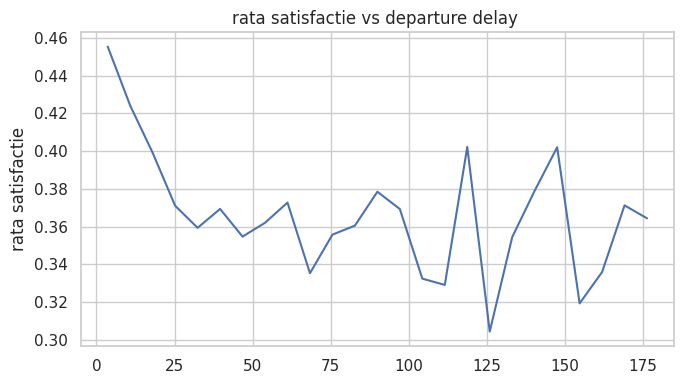

In [24]:


import matplotlib.pyplot as plt

pdf = binned_rate_pdf(train_df, "Departure Delay in Minutes", bins=25, clip_max=180)

print("pdf is None?", pdf is None)
if pdf is not None:
    print("rows:", len(pdf))
    display(pdf.head(10))

    plt.figure(figsize=(7,4))
    plt.plot(pdf["center"], pdf["rate"])
    plt.title("rata satisfactie vs departure delay ")
    plt.ylabel("rata satisfactie")
    plt.tight_layout()
    plt.show()


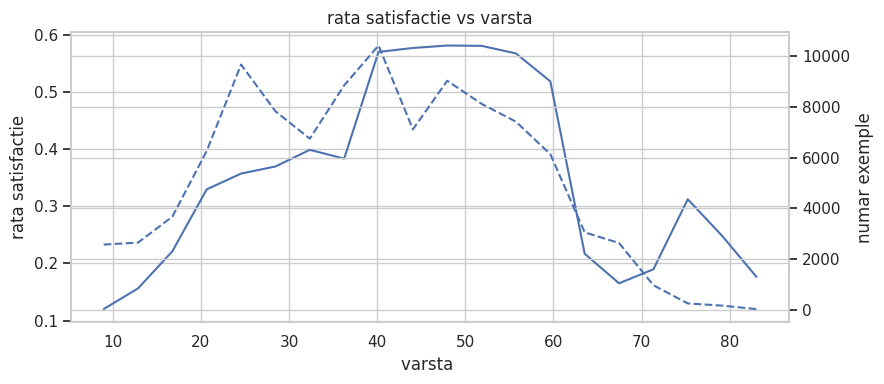

In [26]:
# grafic: rata satisfactie vs varsta (cu n pe fiecare bin)

import matplotlib.pyplot as plt

pdf = binned_rate_pdf(train_df, "Age", bins=20, clip_max=None)

plt.figure(figsize=(9,4))
ax1 = plt.gca()

# linia: rata satisfactie
ax1.plot(pdf["center"], pdf["rate"])
ax1.set_title("rata satisfactie vs varsta")
ax1.set_xlabel("varsta ")
ax1.set_ylabel("rata satisfactie")

# a doua axa: numarul de exemple pe bin
ax2 = ax1.twinx()
ax2.plot(pdf["center"], pdf["n"], linestyle="--")
ax2.set_ylabel("numar exemple")

plt.tight_layout()
plt.show()
